# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [0]:
# This is code to download and install pytorch
import os
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())

    100% |████████████████████████████████| 483.0MB 49.7MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5621c000 @  0x7f11286ba2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 5.3MB/s 
    100% |████████████████████████████████| 2.0MB 5.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Version 0.4.1
CUDA enabled: True


In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'harry_potter/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'harry_potter.txt'):
    !wget http://pjreddie.com/media/files/homework2.tar.gz
    !tar -zxvf homework2.tar.gz
    !rm homework2.tar.gz
import pt_util
os.chdir('/content')

/content
sample_data


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import random
sys.path.append(BASE_PATH)
import pt_util
import math
import matplotlib.pyplot as plt

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path, store_name):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    
    voc2ind = {}
    
    # parameters for making classes and setting class
    illegalChars = set(["\t", "\n", "\r", "\nnn", "\\", "/"]);
    data = list(data)
    i = 0
    classCount = 0
    
    # params for test and train
    trainAmount = math.ceil(len(data) * .8)
    train_text = []
    test_text = []
  
    for c in data:
      # check if the char is illegal and change it
      if c in illegalChars:
        data[i] = " "
        c = " "
      
      # add to voc2ind
      if c not in voc2ind:
        voc2ind[c] = classCount
        classCount += 1
      
      # split into train if first 80%
      
      if i < trainAmount:
        train_text.append(voc2ind[c])
      else:
        test_text.append(voc2ind[c])
      i += 1
    
     # data = "".join(data)
      

    ind2voc = {val: key for key, val in voc2ind.items()}
    

#     train_text = "".join(trainList) # TODO Fill this in
#     test_text = "".join(testList) # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + store_name + '_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + store_name + '_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt', 'harry_potter')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is 2 and the sequence length is 4
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

            
        self.tokens = dataset['tokens']
#         self.tokens = list(range(1, 21))

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.data = {}
        self.label = {}
        
        chars_per_segment = len(self.tokens) // self.batch_size
        n_batches = math.ceil(chars_per_segment / self.sequence_length)

        self.length = n_batches * self.batch_size
        
        for i in range(self.length):
            size = self.sequence_length
            if i // self.batch_size == n_batches - 1:
                size = chars_per_segment % self.sequence_length - 1
                
            data = torch.zeros(size)
            labels = torch.zeros(data.shape)
            
            chunk_start = (i % self.batch_size) * chars_per_segment
            offset = (i // self.batch_size) * sequence_length
            
            read_start = chunk_start + offset
            read_end = read_start + size
            
            row = torch.LongTensor(self.tokens[read_start:read_end])
            label_row = torch.LongTensor(self.tokens[read_start+1:read_end+1])
            
            self.data[i] = row
            self.label[i] = label_row

        
    def __len__(self):
        return self.length
        
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        return self.data[idx], self.label[idx]

    def vocab_size(self):
        return len(self.vocab)
      


# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
        print("vocab size: {}".format(vocab_size))

    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x.long())
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


*italicized text*

In [0]:
BEAM_WIDTH = 4
SAMPLE_SIZE = 3
N = 3


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)

        outputs = []
        # Initializes the beam list.
        beames = [([], output, hidden, 0)]

        for i in range(sequence_length):
            charToAdd = ''

            if sampling_strategy == 'max':
                # TODO max sampling strategy

                charToAdd = torch.max(output, 1)[1]

            elif sampling_strategy == 'sample':
                # TODO: Probability-based sampling strategy.

                charToAdd = torch.multinomial(output, 1)
                

            elif sampling_strategy == 'beam':
                  newBeameList = [] # new list
                  for beame in beames:
                    distrubution = beame[1]
                    contenders = torch.multinomial(distrubution, SAMPLE_SIZE, replacement=True) # chars to use for beame
                    contenders = contenders.view(-1, 1)      
              
                    for c in contenders:
                      currScore = beame[3]
                      logLikehoodScore = currScore + torch.log(distrubution[0][c])
                      dataPoint = torch.Tensor([c]).to(device)
                      newOutput, newHidden = model.inference(dataPoint, beame[2])
                      newChars = beame[0][:] # copies old chars
                      newChars.append(c)
                      newBeameList.append((newChars, newOutput, newHidden, logLikehoodScore))
                  
                  newBeameList = sorted(newBeameList, key=lambda x: x[3], reverse=True)
                  newBeameList = newBeameList[:N]
                  beames = newBeameList[:]
                 
                    
                
            if sampling_strategy != 'beam':
              outputs.append(charToAdd)
              data = torch.Tensor([charToAdd]).to(device)
              output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'beam':
          outputs = list(beames[0][0])
          
        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    correct = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        pred = output.max(-1)[1]
        
        # accuracy
        correct_mask = pred.eq(label.view_as(pred))
        num_correct = correct_mask.sum().item()
        correct += num_correct
        train_accuracy = 100. * correct / (len(train_loader.dataset) * train_loader.dataset.sequence_length)

        
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses), train_accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='elementwise_mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    train_loader.dataset.vocab.array_to_words(data[0]),
                    train_loader.dataset.vocab.array_to_words(label[0]),
                    train_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

    

Using device cuda
num workers: 2
vocab size: 3303
Input	callous," said Dumbledore. "Once and for all, Harry, do I have your word that you will do all in your power to make me keep drinking?" "negotiate -- ?" "Do I have it?" "But--" "Your word, Harry." "I -
GT	," said Dumbledore. "Once and for all, Harry, do I have your word that you will do all in your power to make me keep drinking?" "ingenuity -- ?" "Do I have it?" "But--" "Your word, Harry." "I --
pred	liesinterestedcantparttricktrickhaveplanningplanningPlacesankcountrysanksanklisttrickgrewpassingpassinglistinjuredtrickComeComesevensevenmustvemustvemustvemustvemustvemustvecuriouslycuriouslyregularmustvegrewgrewgrewsevengrewsevenmustvemustvemustvemustveingredientsingredientsfistmustvemustvemustvemustvemustvemustvemustvemagicspreadspreadmustvestrainedPPsanksnakesGreybackmustvemustvemustvestrainedMontagueMontaguemustvemustvemustvemustvemustvemustveignoredwithPottersfacesnakessnakesstrainedstrainedstrainedstrainedwithstrainedpartcountry

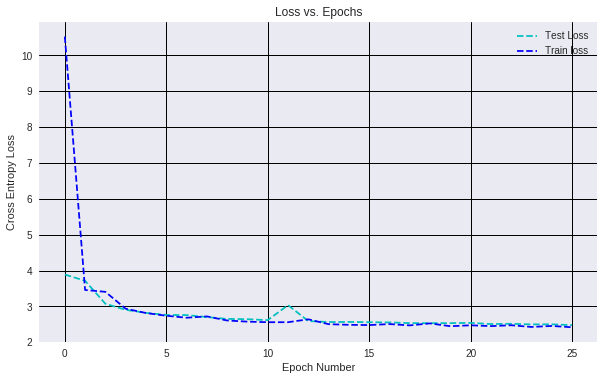

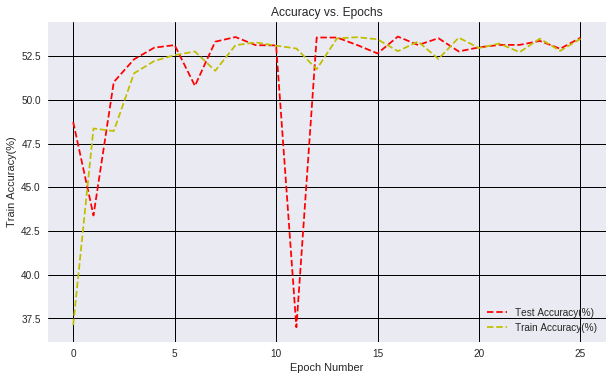

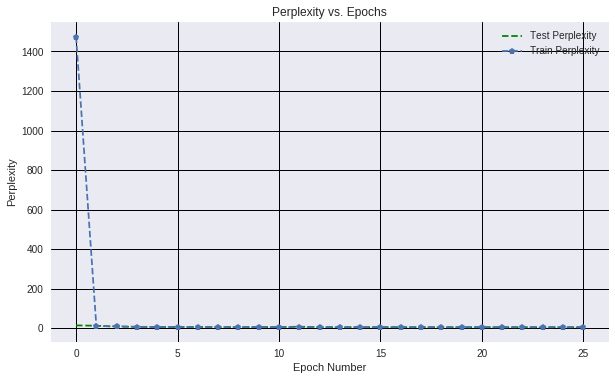

best train loss: 2.41805961728096
best train accuracy: 53.589111328125
best train perplexity: 1475.1739945217275
best test loss: 2.4767307661756686
best test accuracy: 36.99386867088607
best test perplexity: 14.814991468433494

trainLoss: [10.526669412851334, 3.457892030477524, 3.406549686193466, 2.9351222097873686, 2.815518796443939, 2.739421379566193, 2.6838775157928465, 2.7209957778453826, 2.6070743918418886, 2.5747237622737886, 2.5591224193573, 2.559212201833725, 2.6398651599884033, 2.504393482208252, 2.4861746966838836, 2.479231816530228, 2.507168799638748, 2.470290279388428, 2.525915652513504, 2.447434973716736, 2.472618579864502, 2.450125151872635, 2.4744420051574707, 2.426711219549179, 2.454589933156967, 2.41805961728096]
trainAcc: [37.121728515625, 48.367724609375, 48.21904296875, 51.52490234375, 52.22958984375, 52.5654296875, 52.77001953125, 51.667431640625, 53.1326171875, 53.290380859375, 53.1056640625, 52.94228515625, 51.758740234375, 53.5201171875, 53.589111328125, 53.4693

In [0]:
SEQUENCE_LENGTH = 100
BATCH_SIZE = 512
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs/log.pkl'


data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)


# TODO DELETE THIS LATER!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
seed_words = 'Harry Potter'
generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')



# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
start_epoch = 0

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

epochs = []
trainLoss = []
trainAcc = []
trainPerp = []
testLoss = []
testAcc = []
testPerp = []

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss, train_accuracy = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
        
        # Plot code
        epochs.append(epoch)
        trainLoss.append(train_loss)
        trainAcc.append(train_accuracy)
        trainPerp.append(2 ** train_loss)
        
        testLoss.append(test_loss)
        testAcc.append(test_accuracy)
        testPerp.append(2 ** test_loss)
        
        for ii in range(10):
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
    
    plt.figure(figsize=(10,20))
    plt.subplot(3, 1, 1)
    plt.plot(epochs, testLoss, 'c--', label="Test Loss")
    plt.plot(epochs, trainLoss, 'b--', label="Train loss")
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epoch Number")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.grid(True, color='k')
    plt.show(block = False)
    
    plt.figure(figsize=(10,20))
    plt.subplot(3, 1, 2)
    plt.plot(epochs, testAcc, 'r--', label="Test Accuracy(%)")
    plt.plot(epochs, trainAcc, 'y--', label="Train Accuracy(%)")
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epoch Number")
    plt.ylabel("Train Accuracy(%)")
    plt.legend()
    plt.grid(True, color='k')
    plt.show(block = False)
    
    plt.figure(figsize=(10,20))
    plt.subplot(3, 1, 3)
    plt.plot(epochs, testPerp, 'g--', label="Test Perplexity")
    plt.plot(epochs, trainPerp, 'p--', label="Train Perplexity")
    plt.title("Perplexity vs. Epochs")
    plt.xlabel("Epoch Number")
    plt.ylabel("Perplexity")
    plt.legend()
    plt.grid(True, color='k')
    plt.show(block = False)
    
    plt.figure(figsize=(20,10))
    
    plt.savefig(DATA_PATH + 'plots/%03d.pdf' % epoch)
    
    print("best train loss: {}".format(min(trainLoss)))
    print("best train accuracy: {}".format(max(trainAcc)))
    print("best train perplexity: {}".format(max(trainPerp)))
    print("best test loss: {}".format(min(testLoss)))
    print("best test accuracy: {}".format(min(testAcc)))
    print("best test perplexity: {}".format(max(testPerp)))
    
    print('')
    print("trainLoss: {}".format(trainLoss))
    print("trainAcc: {}".format(trainAcc))
    print("trainPerp: {}".format(trainPerp))
    print("testLoss: {}".format(testLoss))
    print("testAcc: {}".format(testAcc))
    print("testPerp: {}".format(testPerp))




In [0]:
epochs = [1, 2]
trainLoss = [4, 5]
trainAcc = [3, 4]
trainPerp = [3, 5]
testLoss = [1, 2]
testAcc = [3, 4]
testPerp = [1, 2]

plt.figure(figsize=(10,20))
plt.subplot(3, 1, 1)
plt.plot(epochs, testLoss, 'c--', label="Test Loss")
plt.plot(epochs, trainLoss, 'b--', label="Train loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True, color='k')
plt.show(block = False)

plt.figure(figsize=(10,20))
plt.subplot(3, 1, 2)
plt.plot(epochs, testAcc, 'r--', label="Test Accuracy(%)")
plt.plot(epochs, trainAcc, 'y--', label="Train Accuracy(%)")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch Number")
plt.ylabel("Train Accuracy(%)")
plt.legend()
plt.grid(True, color='k')
plt.show(block = False)

plt.figure(figsize=(10,20))
plt.subplot(3, 1, 3)
plt.plot(epochs, testPerp, 'g--', label="Test Perplexity")
plt.plot(epochs, trainPerp, 'p--', label="Train Perplexity")
plt.title("Perplexity vs. Epochs")
plt.xlabel("Epoch Number")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True, color='k')
plt.show(block = False)


# plt.savefig(DATA_PATH + 'plots/%03d.pdf' % epoch)

print("best train loss: {}".format(min(trainLoss)))
print("best train accuracy: {}".format(max(trainAcc)))
print("best train perplexity: {}".format(max(trainPerp)))
print("best test loss: {}".format(min(testLoss)))
print("best test accuracy: {}".format(min(testAcc)))
print("best test perplexity: {}".format(max(testPerp)))

#Part 7: Experiments

In [0]:
seed_words = 'Harry Potter and the'
sequence_length = 200

generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
print('generated with max\t', generated_sentence)

for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
    print('generated with sample\t', generated_sentence)
    
for ii in range(10):
    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
    print('generated with beam\t', generated_sentence)

#Part 8: Other things
Choose **two** of the following to try. It will probably be beneficial to create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
2. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
3. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
4. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
5. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



In [0]:
prepare_data(DATA_PATH + 'bible.txt', 'bible')

609


Using device cuda
num workers: 2
vocab size: 3716
Input	 He was just like \ Bella with all the magic indecision. Carlisle laughed \ another weary laugh. \ \ Then we heard Edward\'92s voice inside the house, and \ we both paused to listen. \ \ \'93I\'92ll be right back, 
GT	He was just like \ Bella with all the magic bittern. Carlisle laughed \ another weary laugh. \ \ Then we heard Edward\'92s voice inside the house, and \ we both paused to listen. \ \ \'93I\'92ll be right back, Bella
pred	wouldntwouldntwouldntwouldntwouldntwouldntwouldntwouldntwouldntwouldntwouldnttinytinyentirelytinytinywouldntwouldntwouldnttinytinywouldntlionslionslionshotresisthothothothothotwouldntwouldntwouldnt,cartonguefallingbikefallingwouldnfallingfallingfallingfallingfallingdismayeddismayedbordergivinggottenwitheredwouldntwouldntwouldnttinytinytinytinyjudgeswasmonsterfallingtinyborderbordervisionfallingUntofallingfallingfallingwouldntwouldntstavesJudahdeclaretonguefallingbikefallingbikeborderflowingflowingsor

Process Process-82:
Process Process-81:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3

Interrupted
Saving final model
Saved /gdrive/My Drive/colab_files/homework2/harry_potter/bible_checkpoints/001.pt



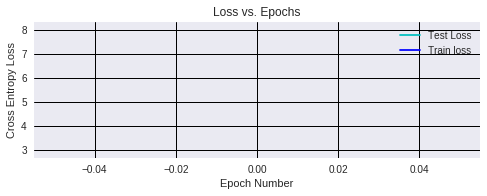

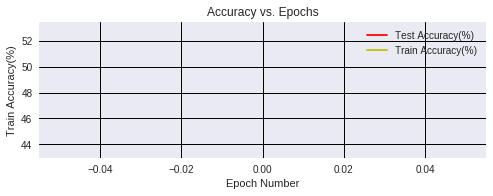

In [0]:
SEQUENCE_LENGTH = 100
BATCH_SIZE = 512
FEATURE_SIZE = 512
TEST_BATCH_SIZE = 512
EPOCHS = 21
LEARNING_RATE = 0.002
WEIGHT_DECAY = 0.0005
USE_CUDA = True
PRINT_INTERVAL = 10
LOG_PATH = DATA_PATH + 'logs/log.pkl'


data_train = HarryPotterDataset(DATA_PATH + 'bible_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
data_test = HarryPotterDataset(DATA_PATH + 'bible_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
vocab = data_train.vocab

use_cuda = USE_CUDA and torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)


# TODO DELETE THIS LATER!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
seed_words = 'I am on team Edward because '



# Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
# We will talk more about different optimization methods in class.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# start_epoch = model.load_last_model(DATA_PATH + 'bible_checkpoints')
start_epoch = 0

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

epochs = []
testAcc = []
trainAcc = []
testLoss = []
trainLoss = []

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
        train_loss, train_accuracy = train(model, device, train_loader, lr, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'bible_checkpoints/%03d.pt' % epoch)
        
        # Plot code
        epochs.append(epoch)
        trainAcc.append(train_accuracy)
        trainLoss.append(train_loss)
        testAcc.append(test_accuracy)
        testLoss.append(test_loss)
        
        
        for ii in range(10):
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            print('generated sample\t', generated_sentence)
        generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
        print('generated beam\t\t', generated_sentence)
        print('')

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print('Saving final model')
    model.save_model(DATA_PATH + 'bible_checkpoints/%03d.pt' % epoch, 0)
    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, testLoss, 'c', label="Test Loss")
    plt.plot(epochs, trainLoss, 'b', label="Train loss")
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epoch Number")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.grid(True, color='k')
    plt.show(block = False)
    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, testAcc, 'r', label="Test Accuracy(%)")
    plt.plot(epochs, trainAcc, 'y', label="Train Accuracy(%)")
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epoch Number")
    plt.ylabel("Train Accuracy(%)")
    plt.legend()
    plt.grid(True, color='k')
    plt.show(block = False)
    plt.savefig(DATA_PATH + 'bible_plots/%03d.pdf' % epoch)


#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called homework2_python.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

2. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
3. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

4. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
5. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

In [0]:
RARITY = 0.001

def prepare_data(data_path, store_name):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    
    voc2ind = {}
    
    # parameters for making classes and setting class
    illegalChars = set(["\t", "\n", "\r", "\nnn", "\\"]);
    punc = set(["\"", "!", ";", ",", ".", "?"])
    data = list(data)
    i = 0
    classCount = 0
    

    
    counts = {}
  
    inWord = False
    tokens = []
    seq = []
    for c in data:
      
      # check if the char is illegal and change it
      if c in illegalChars:
        data[i] = " "
        c = " "
      
      if inWord:
        if not c.isalpha():
          if c != "'":
            if c not in voc2ind:
              voc2ind[c] = classCount
              classCount += 1
              counts[c] = 1
            counts[c] = 1 if c not in counts else counts[c] + 1
            inWord = False
            wordToAdd = "".join(tokens)
            if wordToAdd not in voc2ind:
              voc2ind[wordToAdd] = classCount
              classCount += 1
            counts[wordToAdd] = 1 if wordToAdd not in counts else counts[wordToAdd] + 1
            seq.append(wordToAdd)
            seq.append(c)
            
        else:
          tokens.append(c)
      else:
        if c.isalpha():
          tokens = []
          inWord = True
          tokens.append(c)
        else:
          if c not in voc2ind:
            voc2ind[c] = classCount
            classCount += 1
            counts[c] = 1
          counts[c] = 1 if c not in counts else counts[c] + 1
          seq.append(c)
          
          
      
      
    
     
    

    # Start condensing voc2ind
    size = len(voc2ind)
    condensed = {}

    classCount = 1
    for voc in voc2ind:
      if counts[voc] > RARITY * size:
        condensed[voc] = classCount
        classCount += 1
      else:
        condensed[voc] = 0 # "rare" word
   
    voc2ind = condensed
      
    total_tokens = len(seq)
    trainAmount = math.ceil(total_tokens * .8)
    
    numToToken = [voc2ind[voc] for voc in seq]
    
    train_text = numToToken[:trainAmount]
    test_text = numToToken[trainAmount:]
    
    
    
    
    ind2voc = {val: key for key, val in voc2ind.items()}
        
    # data = "".join(data)
    # params for test and train
    
    
    print(max(numToToken))
    print(max(voc2ind.values()))

    
    

#     train_text = "".join(trainList) # TODO Fill this in
#     test_text = "".join(testList) # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + store_name + '_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + store_name + '_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt', 'harry_potter')
prepare_data(DATA_PATH + 'BibleTwilight.txt', 'bible')




class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        
        
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']
        
        self.rand_set = []
        for rand, key in self.voc2ind.items():
            if key == 0:
              self.rand_set.append(rand)
    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        gen_list = []
        for ind in arr:
            if (int(ind) == 0):
              index = random.randint(0, len(self.rand_set))
              gen_list.append(self.rand_set[index])
            else:
              gen_list.append(self.ind2voc[int(ind)])
              
        return ''.join(gen_list)

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.ind2voc)